### data0 - all car images, including whole and damaged

In [1]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
import pickle as pk
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.utils.data_utils import get_file
# from keras.applications.resnet50 import ResNet50
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

In [3]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

In [4]:
# from Keras GitHub  
def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [6]:
import tensorflow as tf
vgg16 = tf.keras.applications.VGG16(weights='imagenet')

In [7]:
vgg16.save('vgg16.h5')

In [8]:
resnet50 = tf.keras.applications.ResNet50(weights='imagenet')
vgg19 = tf.keras.applications.VGG19(weights='imagenet')
inception = tf.keras.applications.InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 5s 0us/step


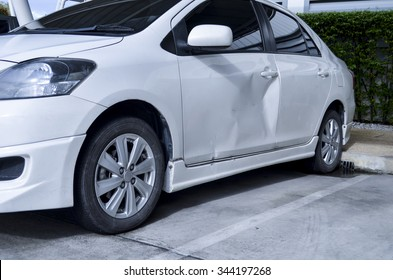

In [10]:
Image('test.jpg', width=200)

In [11]:
def prepare_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

## Testing with different models

In [13]:
y = prepare_image('test.jpg')
preds = vgg16.predict(y)
print(get_predictions(preds, top=5))

49152/35363 [=========================================] - 0s 5us/step
[[('n03770679', 'minivan', 0.9096674), ('n03100240', 'convertible', 0.016054722), ('n03670208', 'limousine', 0.015147428), ('n02814533', 'beach_wagon', 0.01360543), ('n03769881', 'minibus', 0.011686187)]]


In [17]:
z = preprocess_input(y)
preds = resnet50.predict(z)
print(get_predictions(preds))

[[('n02974003', 'car_wheel', 0.9647015), ('n03770679', 'minivan', 0.013139535), ('n03459775', 'grille', 0.009299792), ('n02930766', 'cab', 0.0036834027), ('n04355933', 'sunglass', 0.001051464)]]


In [19]:
a = preprocess_input(y)
preds = vgg19.predict(a)
print(get_predictions(preds))

[[('n03770679', 'minivan', 0.98280776), ('n02974003', 'car_wheel', 0.012937294), ('n02814533', 'beach_wagon', 0.0015132407), ('n04285008', 'sports_car', 0.0007749883), ('n04065272', 'recreational_vehicle', 0.0006877091)]]


## Using VGG16 as Gate

In [35]:
def get_car_categories():
    d = defaultdict(float)
    path = 'dataset/data1a/training/00-damage'
    img_list = os.listdir(path)
    for i, img_path in enumerate(img_list):
        img = prepare_image(os.path.join(path, img_path))
        out = vgg16.predict(img)
        top = get_predictions(out, top=5)
        for j in top[0]:
            d[j[0:2]] += j[2]
        if i % 50 == 0:
            print(i, '/', len(img_list), 'complete')
    return Counter(d)

In [36]:
cat_counter = get_car_categories()

0 / 920 complete
50 / 920 complete
100 / 920 complete
150 / 920 complete
200 / 920 complete
250 / 920 complete
300 / 920 complete
350 / 920 complete
400 / 920 complete
450 / 920 complete
500 / 920 complete
550 / 920 complete
600 / 920 complete
650 / 920 complete
700 / 920 complete
750 / 920 complete
800 / 920 complete
850 / 920 complete
900 / 920 complete


In [37]:
with open('cat_counter.pk', 'wb') as f:
    pk.dump(cat_counter,f,-1)

### Load Pickle Point

In [38]:
with open('cat_counter.pk', 'rb') as f:
    cat_counter = pk.load(f)

In [39]:
cat_list = [k for k, v in cat_counter.most_common()[:50]]

## Evaluating Car Categories from Imagenet

In [45]:
def get_car_categories(cat_list):
    path = 'dataset/data1a/training/00-damage'
    img_list = os.listdir(path)
    num = 0
    bad_list = []
    for i, img_path in enumerate(img_list):
        img = prepare_image(os.path.join(path, img_path))
        out = vgg16.predict(img)
        top = get_predictions(out, top=5)
        for j in top[0]:
            if j[0:2] in cat_list:
                num += 1
                break # breaks out of for loop if one of top 50 categories is found
            else:
                pass
            bad_list.append(img_path) # appends to "bad list" if none of the 50 are found
        if i % 100 == 0:
            print(i, '/', len(img_list), 'complete')
    bad_list = [k for k, v in Counter(bad_list).items() if v == 5]
    return num, bad_list

In [46]:
number, bad_list = get_car_categories(cat_list)

0 / 920 complete
100 / 920 complete
200 / 920 complete
300 / 920 complete
400 / 920 complete
500 / 920 complete
600 / 920 complete
700 / 920 complete
800 / 920 complete
900 / 920 complete


In [54]:
number2, bad_list2 = car_categories_gate(cat_list2)

In [56]:
number2, bad_list2 = car_categories_gate(cat_list2)

TypeError: car_categories_gate() missing 1 required positional argument: 'cat_list'

## Select top 50 as cutoff for category list

In [60]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(os.path.join(img_dir, img)))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

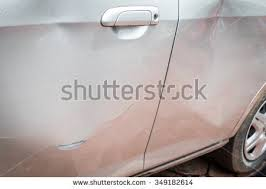

c to continue, q to quitc


In [61]:
view_images('dataset/data1a/training/00-damage', bad_list)

In [62]:
view_images('dataset/data1a/training/00-damage', bad_list2)

NameError: name 'bad_list2' is not defined

## Gate Implementation

In [63]:
def car_categories_gate(image_path, cat_list):
    urllib.urlretrieve(image_path, 'save.jpg') # or other way to upload image
    img = prepare_image('save.jpg')
    out = vgg16.predict(img)
    top = get_predictions(out, top=5)
    print "Validating that this is a picture of your car..."
    for j in top[0]:
        if j[0:2] in cat_list:
            print(j[0:2])
            return "Validation complete - proceed to damage evaluation"
    return "Are you sure this is a picture of your car? Please take another picture (try a different angle or lighting) and try again."

SyntaxError: Missing parentheses in call to 'print'. Did you mean print("Validating that this is a picture of your car...")? (Temp/ipykernel_36436/2008987645.py, line 6)

In [17]:
car_categories_gate('https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcSxhKhaSwPgdQkrDegC6sbUALBF9SiW6tDKg6dLDYj83e19krxy', cat_list)

Validating that this is a picture of your car...
(u'n02930766', u'cab')


'Validation complete - proceed to damage evaluation'

In [20]:
car_categories_gate('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7xHO3j12Xk4q4eaQUL1A02k1HrJ9G_RY6tj-4h-07EfdML6YL', cat_list)

Validating that this is a picture of your car...
(u'n03445924', u'golfcart')


'Validation complete - proceed to damage evaluation'